In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import librosa
import io
import os

In [3]:
base_name = 'train-00000-of-00016-6b5481c76a3d2702'

parquet_file_path = f'music/{base_name}.parquet'

In [4]:

# Load the data into a pandas DataFrame
df = pd.read_parquet(parquet_file_path, engine='pyarrow')

In [5]:
df.head()

,audio,song_id,genre_id,genre
0,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,0,0,Electronic
1,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,1,9,International
2,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,2,6,Chiptune / Glitch
3,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,4,4,Hip-Hop
4,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,5,14,Country


In [6]:
df.columns

Index(['audio', 'song_id', 'genre_id', 'genre'], dtype='object')

In [7]:
def decode_audio(binary_data):
    # Convert bytes to file-like object
    audio_file = io.BytesIO(binary_data)
    
    # Load audio file using librosa
    y, sr = librosa.load(audio_file, sr=None)  # `sr=None` to keep the original sampling rate
    
    return y, sr

In [8]:
# Decode audio for each row in the DataFrame
df['decoded_audio'] = df['audio'].apply(lambda x: decode_audio(x['bytes']))

# Example of how to access the decoded audio and sampling rate
decoded_audio, sampling_rate = df['decoded_audio'][0]  # Accessing the first row as an example
print(f"Decoded Audio: {decoded_audio}")
print(f"Sampling Rate: {sampling_rate}")

# If you want to extract just the time series (audio data) and store it separately
df['audio_time_series'] = df['decoded_audio'].apply(lambda x: x[0])  # Extract time series data
df['sampling_rate'] = df['decoded_audio'].apply(lambda x: x[1])  # Extract sampling rate

Decoded Audio: [ 3.9714024e-07  7.3031049e-07  7.5640696e-07 ... -1.1963670e-01
 -1.1681189e-01 -1.1244176e-01]
Sampling Rate: 44100


In [9]:
df = df.drop(['decoded_audio','audio'], axis=1)

In [10]:
df.head()

,song_id,genre_id,genre,audio_time_series,sampling_rate
0,0,0,Electronic,"[3.9714024e-07, 7.303105e-07, 7.5640696e-07, 4...",44100
1,1,9,International,"[0.15237975, 0.13222949, 0.10627693, 0.0847923...",44100
2,2,6,Chiptune / Glitch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100
3,4,4,Hip-Hop,"[1.0242003e-07, -2.1464828e-08, 4.3254058e-08,...",44100
4,5,14,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100


Longitudes únicas de audios: [ 660719 1321967 1323119 1439471]
Longitud 660719: 2 ejemplos
Longitud 1321967: 661 ejemplos
Longitud 1323119: 531 ejemplos
Longitud 1439471: 51 ejemplos
Sampling Rate únicos de audios: [22050 44100 48000]
Longitud 22050: 2 ejemplos
Longitud 44100: 1192 ejemplos
Longitud 48000: 51 ejemplos


<function matplotlib.pyplot.show(close=None, block=None)>

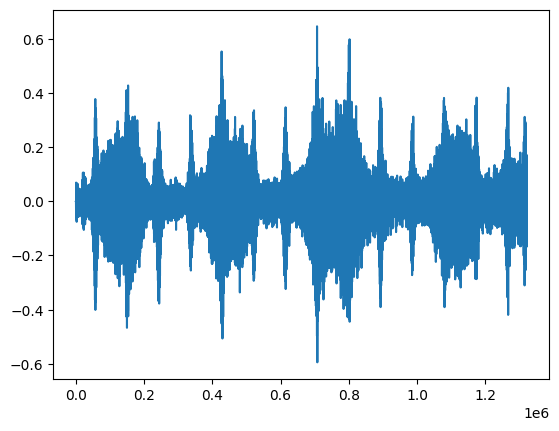

In [11]:
# Calculate the length of each audio time series
lens = [len(ts) for ts in df['audio_time_series']]
# Find unique lengths and their counts
unique_lengths, counts_len = np.unique(lens, return_counts=True)
# Print unique lengths and the number of examples for each length
print(f"Longitudes únicas de audios: {unique_lengths}")
for length, count in zip(unique_lengths, counts_len):
    print(f"Longitud {length}: {count} ejemplos")

unique_sr, counts_sr = np.unique(df.sampling_rate, return_counts=True)
# Print unique lengths and the number of examples for each sampling rate
print(f"Sampling Rate únicos de audios: {unique_sr}")
for length, count in zip(unique_sr, counts_sr):
    print(f"Longitud {length}: {count} ejemplos")


plt.plot(df.audio_time_series[10])
plt.show

Most common sampling rate: 44100


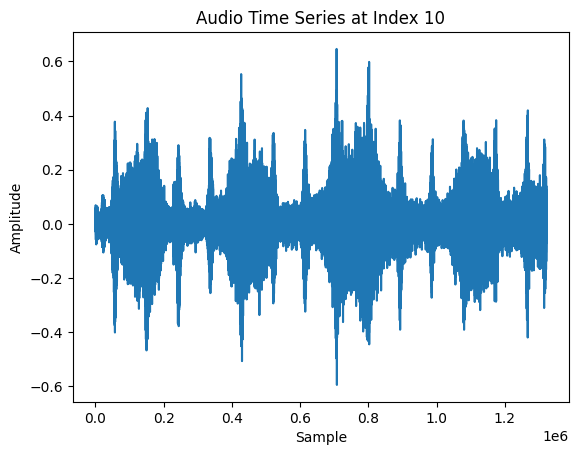

In [12]:
# 1. Identify the most common sampling rate
most_common_sampling_rate = df['sampling_rate'].mode()[0]
print(f"Most common sampling rate: {most_common_sampling_rate}")

# 2. Filter the DataFrame to include only examples with the most common sampling rate
filtered_df = df[df['sampling_rate'] == most_common_sampling_rate]

# Display some of the padded time series to verify
plt.plot(filtered_df['audio_time_series'].iloc[10])
plt.title("Audio Time Series at Index 10")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [13]:
len(df)

1245

In [14]:
len(filtered_df)

1192

In [15]:
import gc

# Delete the DataFrame
del df

# Run garbage collection
gc.collect()

4386

In [16]:
# 1. Identify the most common genre
most_common_genre = filtered_df['genre'].mode()[0]
print(f"Most common genre: {most_common_genre}")

# 2. Filter the DataFrame to include only examples with the most common genre
filtered_genre_df = filtered_df[filtered_df['genre'] == most_common_genre]

# Display the number of examples remaining
print(f"Number of examples with the most common genre: {len(filtered_genre_df)}")

# Optionally, you can inspect the first few rows of the filtered DataFrame
print(filtered_genre_df.head())

Most common genre: Electronic
Number of examples with the most common genre: 196
    song_id  genre_id       genre  \
0         0         0  Electronic   
8        12         0  Electronic   
14       19         0  Electronic   
28       39         0  Electronic   
30       41         0  Electronic   

                                    audio_time_series  sampling_rate  
0   [3.9714024e-07, 7.303105e-07, 7.5640696e-07, 4...          44100  
8   [-0.086568944, -0.058528088, -0.12844338, -0.2...          44100  
14  [1.6128641e-06, 1.3899444e-06, 1.1362536e-06, ...          44100  
28  [-3.0545246e-09, -2.2721935e-08, -3.0839455e-0...          44100  
30  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          44100  


In [17]:
len(filtered_genre_df)

196

In [18]:
filtered_genre_df.head()

,song_id,genre_id,genre,audio_time_series,sampling_rate
0,0,0,Electronic,"[3.9714024e-07, 7.303105e-07, 7.5640696e-07, 4...",44100
8,12,0,Electronic,"[-0.086568944, -0.058528088, -0.12844338, -0.2...",44100
14,19,0,Electronic,"[1.6128641e-06, 1.3899444e-06, 1.1362536e-06, ...",44100
28,39,0,Electronic,"[-3.0545246e-09, -2.2721935e-08, -3.0839455e-0...",44100
30,41,0,Electronic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100


In [19]:
len(filtered_genre_df["audio_time_series"].iloc[10])

1323119

In [20]:
# Create the output folder if it doesn't exist
output_folder = 'music_preprocessed_planarVAE'
os.makedirs(output_folder, exist_ok=True)

# Define the target length for chunks (5 seconds at 44100 Hz)
target_length = 44100 * 5

# Function to split and pad time series
def split_and_pad_time_series(time_series, target_length):
    chunks = []
    for start in range(0, len(time_series), target_length):
        chunk = time_series[start:start + target_length]
        if len(chunk) < target_length:
            chunk = np.pad(chunk, (0, target_length - len(chunk)), mode='constant')
        chunks.append(chunk)
    return chunks

# Iterate over the filtered DataFrame and save each chunked and padded time series
for idx, row in filtered_genre_df.iterrows():
    # Get the original time series
    time_series = row['audio_time_series']
    
    # Split and pad the time series into chunks
    chunks = split_and_pad_time_series(time_series, target_length)
    
    # Save each chunk as a separate .npy file
    for chunk_idx, chunk in enumerate(chunks):
        file_path = os.path.join(output_folder, f'audio_{idx}_chunk_{chunk_idx}.npy')
        np.save(file_path, chunk)

print(f"All time series chunks have been saved to {output_folder}.")

All time series chunks have been saved to music_preprocessed_planarVAE.
